In [64]:
import matplotlib.pyplot as plt
import random as rdn
import numpy as np
import scipy
import math
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from iminuit import Minuit
import pandas as pd
import time 
import math
import library


#importation des donnés RSD
df = pd.read_csv("fsigma8_data.dat", sep=";")
z_data = np.array((df['z'].copy()).tolist())
fsig8 = np.array((df['fsig8'].copy()).tolist())
fsig8_err_minus = np.array((df['fsig8_err_minus'].copy()).tolist())
fsig8_err_plus = np.array((df['fsig8_err_plus'].copy()).tolist())

In [65]:
minimizer = Minuit(library.Chi2,H0 = 70,omega_m0 = 0.3,M=-15,sigma8_0 = 0.7 ,w = -1)
minimizer.limits["omega_m0"] = (0,1)
minimizer.limits["sigma8_0"] = (0,1)  # Valeurs plus physiques
minimizer.fixed["w"] = True
minimizer.limits["H0"] = (0,100)
minimizer.limits["M"] = (-20,-15)
minimizer.errordef = 1.0  # Pour chi2
minimizer.strategy = 2    # Plus précis
result = minimizer.migrad()
print(result)

# Statistiques du fit
chi2_val = minimizer.fval
ndof = len(fsig8) - len(minimizer.parameters)
chi2_reduit = chi2_val / ndof

print(f"\nRésultats du fit :")
print(f"Chi2 = {chi2_val:.2f}")
print(f"Nombre de degrés de liberté = {ndof}")
print(f"Chi2 réduit = {chi2_reduit:.2f}")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega_m0']:.3f} ± {minimizer.errors['omega_m0']:.3f}")
print(f"σ8,0 = {minimizer.values['sigma8_0']:.3f} ± {minimizer.errors['sigma8_0']:.3f}")
print(f"H0 = {minimizer.values['H0']:.3f} ± {minimizer.errors['H0']:.3f}")
print(f"M = {minimizer.values['M']:.3f} ± {minimizer.errors['M']:.3f}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1533                       │              Nfcn = 218              │
│ EDM = 1.15e-09 (Goal: 0.0002)    │           time = 19.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_27056\232100269.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fit $f\sigma_8$ (approximation analytique)')


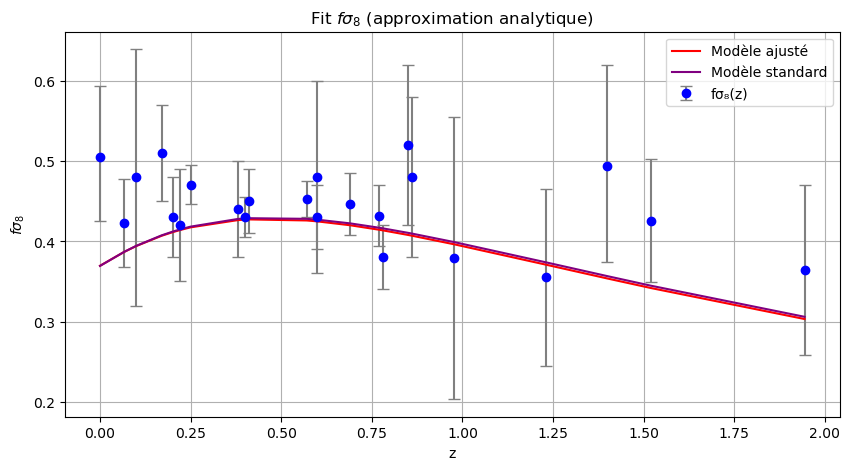

In [ ]:
omega_m0_fit = minimizer.values["omega_m0"]
sigma8_0_fit = minimizer.values["sigma8_0"]

w_fit = minimizer.values["w"]
om_ms = 0.334
S8_ms = 0.81
sig8_ms = S8_ms*(0.3/om_ms)**(0.5)
gamma_fit = library.gamma(omega_m0_fit,w_fit,z_data)
modele = library.omega_mGamma(z_data, gamma_fit, omega_m0_fit,w_fit) * np.array(library.sigma8(sigma8_0_fit, omega_m0_fit, z_data,w_fit))
gamma_modele_standard = library.gamma(om_ms, -1,z_data)
modele_standard = library.omega_mGamma(z_data, gamma_modele_standard, 0.334,-1) * np.array(library.sigma8(sig8_ms,om_ms,z_data,-1))

# --- Plot 1 : Fit et données ---
plt.figure(figsize=(10, 5))
plt.errorbar(z_data, fsig8, yerr=[fsig8_err_minus, fsig8_err_plus], fmt='o', ecolor='gray', elinewidth=1.5, capsize=4, label="fσ₈(z)", color='blue')
plt.plot(z_data, modele, 'r-', label='Modèle ajusté')
plt.plot(z_data, modele_standard, color='purple', linestyle='-', label='Modèle standard')
plt.xlabel('z')
plt.ylabel(r'$f\sigma_8$')
plt.title('Fit $f\sigma_8$ (approximation analytique)')
plt.legend()
plt.grid(True)

In [67]:
from tqdm import tqdm  # pour la barre de progression (facultatif)
N = 100
omega_m0_vals = np.linspace(0.2,0.5,N)
sigma8_0_vals = np.linspace(0.6,1,N)


# On va projeter sur chaque plan 2D en fixant le troisième paramètre à sa valeur best-fit
chi2_grid_om_si8 = np.zeros((len(omega_m0_vals), len(sigma8_0_vals)))


# Best-fit
om_best = minimizer.values['omega_m0']
sig8_best = minimizer.values['sigma8_0']
w_best = minimizer.values['w']
M_fit = minimizer.values['M']
H0 = minimizer.values['H0']

def compute_grid_Chi2(omega_vals, sigma_vals,H0,M_fit,w):
    # Ωm0 vs σ8 (w fixé)
    OM, Sig8 = np.meshgrid(omega_vals, sigma_vals, indexing='ij')
    chi2_grid_om_sig8 = np.vectorize(lambda om, sig8: library.Chi2(H0,om,M,sig8,w))(OM, Sig8)
    return chi2_grid_om_sig8


# --- Calcul des grilles ---
print("Début du calcul des grilles χ² vectorisées...")


tab_grid = np.array([])

tab_grid = []

start = time.time()

# Calcul de la grille

H0_late = 73.4
H0_early = 67.4
M = -19.25
w = -1
chi2_grid = compute_grid_Chi2(omega_m0_vals, sigma8_0_vals,H0,M_fit,w)
chi2_grid_late_uni = compute_grid_Chi2(omega_m0_vals, sigma8_0_vals,H0_late,M,w)
chi2_grid_early_uni = compute_grid_Chi2(omega_m0_vals, sigma8_0_vals,H0_early,M,w)

tab_grid.append(chi2_grid)
tab_grid.append(chi2_grid_late_uni)
tab_grid.append(chi2_grid_early_uni)

# Trouver le min dans la grille
end = time.time()
print(f"w : grille calculée en {end - start:.2f}s")



Début du calcul des grilles χ² vectorisées...
w : grille calculée en 2547.08s


In [70]:
sig8_ms = 0.81 * (0.3 / om_ms) ** (0.5)

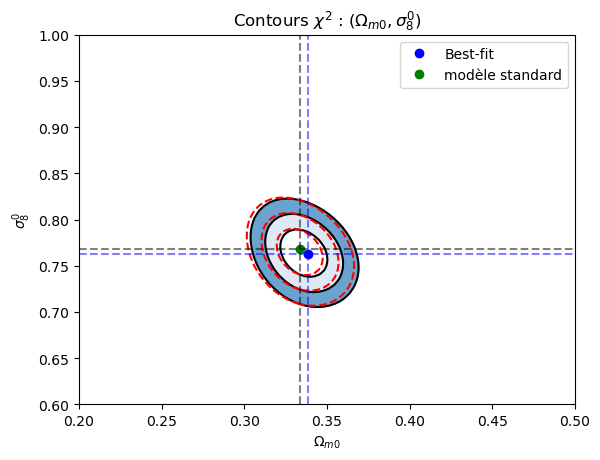

In [71]:
# --- Niveaux pour les contours (Δχ² pour 2 paramètres libres) ---
levels = [minimizer.fval + d for d in [2.30, 6.18, 11.83]]  # 1σ, 2σ, 3σ

# Ωm0 vs sig8 (w fixé)
cf1 = plt.contourf(omega_m0_vals, sigma8_0_vals, chi2_grid.T, levels=levels, cmap='Blues', alpha=0.7)
c1 = plt.contour(omega_m0_vals, sigma8_0_vals, chi2_grid.T, levels=levels, colors='k')
# Contours modèle standard (en tirets rouges)
early_ms = plt.contour(omega_m0_vals, sigma8_0_vals, chi2_grid_early_uni.T, levels=levels, colors='g', linestyles='dashed')
late_ms = plt.contour(omega_m0_vals, sigma8_0_vals, chi2_grid_late_uni.T, levels=levels, colors='r', linestyles='dashed')
plt.plot(om_best, sig8_best, 'bo', label='Best-fit')
plt.axvline(om_best, color='blue', linestyle='--', alpha=0.5)
plt.axhline(sig8_best, color='blue', linestyle='--', alpha=0.5)
plt.plot(om_ms, sig8_ms, 'go', label='modèle standard')
plt.axvline(om_ms, color='black', linestyle='--', alpha=0.5)
plt.axhline(sig8_ms, color='black', linestyle='--', alpha=0.5)
plt.xlabel(r'$\Omega_{m0}$')
plt.ylabel(r'$\sigma_8^0$')
plt.title(r'Contours $\chi^2$ : $(\Omega_{m0}, \sigma_8^0)$')
plt.legend()